In [1]:
!pip install torch torchvision torchaudio transformers scikit-learn matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [1]:
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from torchvision import transforms
import argparse
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import torchaudio
import pandas as pd

# train.zip path in colab
zip_path = "/content/train.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content/data")

loaded


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ASTMLPHead(
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dense): Linear(in_features=768, out_features=527, bias=True)
)
Epoch 1: Train Loss = 0.2174, Val Loss = 1.4184
Epoch 2: Train Loss = 0.1800, Val Loss = 1.6672
Epoch 3: Train Loss = 0.1588, Val Loss = 1.3409
Epoch 4: Train Loss = 0.1320, Val Loss = 1.5936
Epoch 5: Train Loss = 0.1085, Val Loss = 1.5615
Epoch 6: Train Loss = 0.0808, Val Loss = 1.7606
Epoch 7: Train Loss = 0.0619, Val Loss = 1.9623
Epoch 8: Train Loss = 0.0483, Val Loss = 2.2698
Epoch 9: Train Loss = 0.0389, Val Loss = 2.3621
Epoch 10: Train Loss = 0.0330, Val Loss = 2.4538
Final Evaluation:
              precision    recall  f1-score   support

           0     0.9468    0.9273    0.9369      2282
           1     0.7830    0.8343    0.8078       718

    accuracy                         0.9050      3000
   macro avg     0.8649    0.8808    0.8724      3000
weighted avg     0.9076    0.9050    0.9060      3000



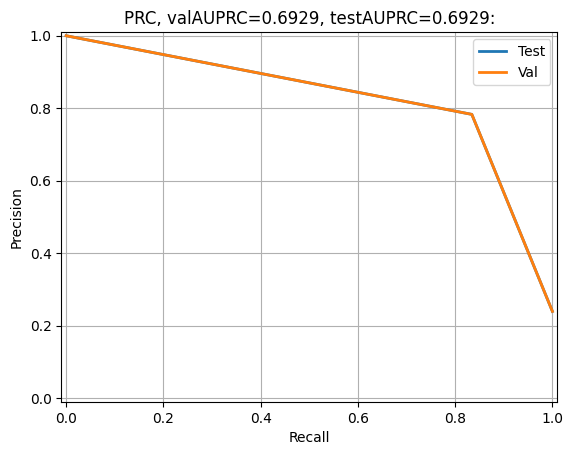

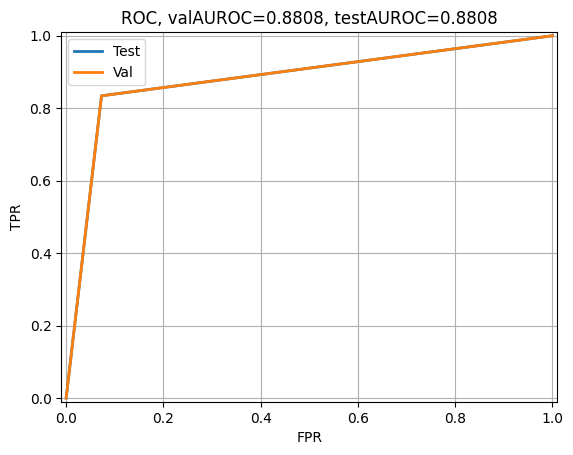

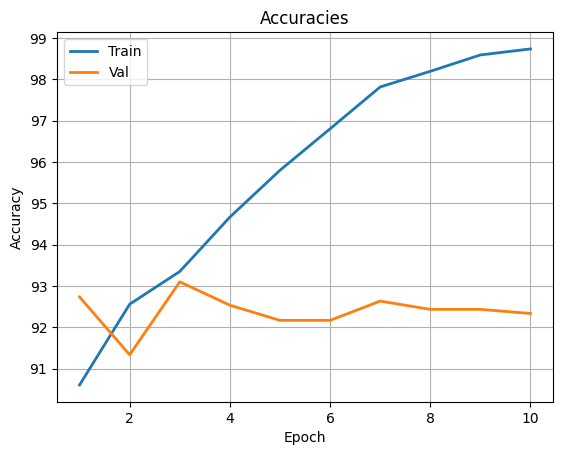

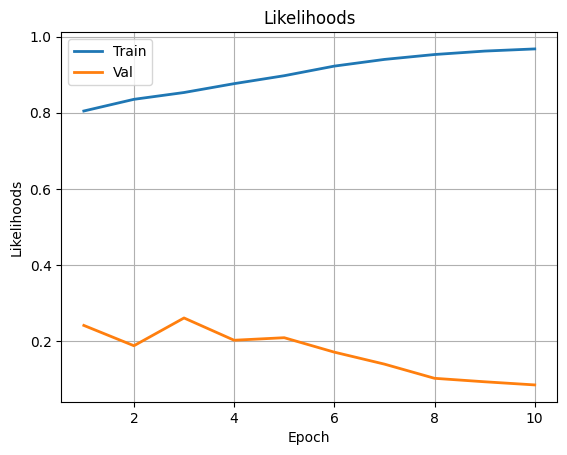

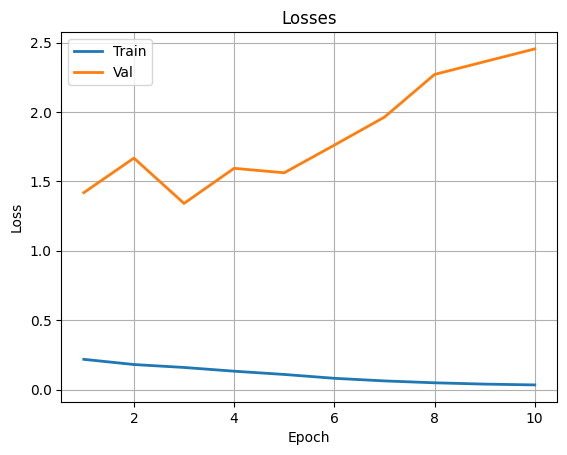


Test AUPRC: 0.69
Test AUROC: 0.88
Val  AUPRC: 0.69
Val  AUROC: 0.88

Final Train Accuracy: 98.74
Final Val Accuracy: 92.33
Final Test Accuracy: 90.50

Final Train Loss: 0.03
Final Val Loss: 2.45


In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_path, labels_path):

        self.df = pd.read_csv(labels_path)

        # Create data and labels
        self.data = [os.path.join(data_path, fname) for fname in self.df["clip_name"]]
        self.labels = torch.tensor(self.df["label"].values).long()

        # AST features
        self.feature_extractor = ASTFeatureExtractor()



    def __len__(self):
        return len(self.data)



    def __getitem__(self, idx):

        file_path = self.data[idx]
        waveform, sample_rate = torchaudio.load(file_path)

        # Resample to 16k
        waveform = torchaudio.functional.resample(waveform, orig_freq=sample_rate, new_freq=16000)


        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # ASTFeatureExtractor looks for shape: (time, freq)
        inputs = self.feature_extractor(waveform.squeeze(0), sampling_rate=16000, return_tensors="pt")
        x = inputs["input_values"].squeeze(0)
        y = self.labels[idx]
        return x, y



def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        outputs = model(x).logits
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.detach().cpu().numpy())
    return (running_loss / len(loader.dataset)), all_labels, all_preds

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x).logits
            preds = torch.argmax(logits, dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())
    return classification_report(all_labels, all_preds, digits=4, zero_division=0), np.array(all_labels), np.array(all_preds)


def split_dataset(dataset, val_pct=0.1, test_pct=0.1):
    total_size = len(dataset)
    val_size = int(val_pct * total_size)
    test_size = int(test_pct * total_size)
    train_size = total_size - val_size - test_size
    return torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curve.png")
    plt.show()

def plot_complete(train_losses, val_losses, train_accuracies, val_accuracies, test_labels, test_preds, val_labels, val_preds):

    # Main process taken from resultsVisualization.py and modified
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    train_accuracies = np.array(train_accuracies)
    val_accuracies = np.array(val_accuracies)
    test_labels = np.array(test_labels)
    test_preds = np.array(test_preds)
    val_labels = np.array(val_labels)
    val_preds = np.array(val_preds)

    testPrecision, testRecall, testAP, testFPR, testTPR, testAUCROC = extractMetrics(test_preds, test_labels)
    valPrecision, valRecall, valAP, valFPR, valTPR, valAUCROC = extractMetrics(test_preds, test_labels)


    # PLOT AUPRC
    plt.plot(testRecall, testPrecision, linewidth=2, label="Test")
    plt.plot(valRecall, valPrecision, linewidth=2, label="Val")
    plt.ylim(-0.01, 1.01)
    plt.xlim(-0.01, 1.01)
    plt.title('PRC, valAUPRC={:.4f}, testAUPRC={:.4f}:'.format(valAP, testAP))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.legend(loc=0)
    plt.savefig("AUPRC_AST.png")
    plt.show()


    # PLOT AUROC
    plt.plot(testFPR, testTPR, linewidth=2, label='Test')
    plt.plot(valFPR, valTPR, linewidth=2, label='Val')
    plt.ylim(-0.01, 1.01)
    plt.xlim(-0.01, 1.01)
    plt.title('ROC, valAUROC={:.4f}, testAUROC={:.4f}'.format(valAUCROC, testAUCROC))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend(loc=0)
    plt.savefig("AUROC_AST.png")
    plt.show()

    # PLOT ACCURACY
    plt.plot(np.arange(1, len(train_accuracies)+1), train_accuracies, linewidth=2, label='Train')
    plt.plot(np.arange(1, len(val_accuracies)+1), val_accuracies, linewidth=2, label='Val')
    plt.title('Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc=0)
    plt.savefig("ACCURACY_AST.png")
    plt.show()

    # PLOT Norm-Likelihood
    plt.plot(np.arange(1, len(np.exp(-train_losses))+1), np.exp(-train_losses), linewidth=2, label='Train')
    plt.plot(np.arange(1, len(np.exp(-val_losses))+1), np.exp(-val_losses), linewidth=2, label='Val')
    plt.title('Likelihoods')
    plt.xlabel('Epoch')
    plt.ylabel('Likelihoods')
    plt.grid()
    plt.legend(loc=0)
    plt.savefig("Norm-Likelihood_AST.png")
    plt.show()

    # PLOT LOSS
    plt.plot(np.arange(1, len(train_losses)+1), train_losses, linewidth=2, label='Train')
    plt.plot(np.arange(1, len(val_losses)+1), val_losses, linewidth=2, label='Val')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc=0)
    plt.savefig("LOSS_AST.png")
    plt.show()


    print("\nTest AUPRC: {:.2f}".format(testAP))
    print("Test AUROC: {:.2f}".format(testAUCROC))

    print("Val  AUPRC: {:.2f}".format(valAP))
    print("Val  AUROC: {:.2f}".format(valAUCROC))

    #print(train_accuracies[0:10])
    print("\nFinal Train Accuracy: {:.2f}".format(train_accuracies[-1]))
    print("Final Val Accuracy: {:.2f}".format(val_accuracies[-1]))

    test_accuracies = accuracy_score(test_labels, test_preds)*100
    print("Final Test Accuracy: {:.2f}".format(test_accuracies))

    print("\nFinal Train Loss: {:.2f}".format(train_losses[-1]))
    print("Final Val Loss: {:.2f}".format(val_losses[-1]))




def extractMetrics(softPredictions, targets):
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
    """
    Given soft predictions and true target labels, compute evaluation metrics:
      - precision, recall: for Precision-Recall curve,
      - AP: average precision score,
      - FPR, TPR: false positive and true positive rates for ROC curve,
      - AUCROC: area under the ROC curve.

    Arguments:
      softPredictions: numpy array of soft output predictions.
      targets: numpy array of binary true labels (0 or 1).

    Returns:
      precision, recall, ap, fpr, tpr, aucroc
    """
    sp = softPredictions.ravel()
    t = targets.ravel()
    precision, recall, _ = precision_recall_curve(t, sp)
    ap = average_precision_score(t, sp)
    fpr, tpr, _ = roc_curve(t, sp)
    aucroc = roc_auc_score(t, sp)
    return precision, recall, ap, fpr, tpr, aucroc


def main(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = SpectrogramDataset(data_path=os.path.join(args.dataDir, "train"),
    labels_path=os.path.join(args.dataDir, "train.csv"))
    train_set, val_set, test_set = split_dataset(train_dataset)

    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=args.batch_size)
    test_loader = DataLoader(test_set, batch_size=args.batch_size)
    print("loaded")

    model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
    print(model.classifier)

    model.classifier = nn.Linear(model.classifier.dense.in_features, 2)  # Binary classification
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(args.epochs):

        # Training
        model.train()
        total_train_loss = 0

        loss, train_labels, train_preds = train(model, train_loader, optimizer, criterion, device)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy * 100)
        #print(f"Epoch {epoch+1}/{args.epochs}, Loss: {loss:.4f}")

        avg_train_loss = loss
        train_losses.append(avg_train_loss)


        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
          for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            outputs = model(x).logits
            loss = criterion(outputs, y)

            total_val_loss += loss.item() * x.size(0)

        _,val_labels, val_preds = evaluate(model, val_loader, device)
        val_acc = accuracy_score(val_labels, val_preds)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc * 100)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    #plot_loss(train_losses, val_losses)


    """
    model.eval()
    true, preds = [], []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            outputs = model(x).logits
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            true.extend(y.numpy()) """


    # Use Testing set
    print("Final Evaluation:")
    classification_report, test_labels, test_preds = evaluate(model, test_loader, device)
    print(classification_report)
    plot_complete(train_losses, val_losses, train_accuracies, val_accuracies, test_labels, test_preds, val_labels, val_preds)


class Args:
    dataDir = "/content/data"
    epochs = 10
    batch_size = 8
    lr = 5e-5

args = Args()
main(args)
